In [1]:
import keras

import numpy as np

import matplotlib.pyplot as plt

import sklearn.decomposition
import sklearn.neighbors
import sklearn.manifold

import random

import time

import numba

Using TensorFlow backend.


In [2]:
REGULAR_EPOCHS = 80
REGULAR_BATCH_SIZE = 128
PRETRAIN_EPOCHS = 50

<a id="segundo"></a>
## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen

---

a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

In [3]:
(x_training, y_training), (x_test, y_test) = keras.datasets.mnist.load_data()
x_training = x_training.astype('float32')/255.
x_test  = x_test.astype('float32') /255.

# Shuffle train data:
n_vali = 5000
indexes = np.arange(x_training.shape[0])
np.random.shuffle(indexes)

x_val = x_training[indexes[:n_vali]]
y_val = y_training[indexes[:n_vali]]
x_tra = x_training[indexes[n_vali:]]
y_tra = y_training[indexes[n_vali:]]

print("x_val.shape",x_val.shape)
print("y_val.shape",y_val.shape)
print("x_tra.shape",x_tra.shape)
print("y_tra.shape",y_tra.shape)
print("x_test.shape",x_test.shape)
print("y_test.shape",y_test.shape)

x_val.shape (5000, 28, 28)
y_val.shape (5000,)
x_tra.shape (55000, 28, 28)
y_tra.shape (55000,)
x_test.shape (10000, 28, 28)
y_test.shape (10000,)


---

### 2.1 Reducción de dimensionalidad
Para esta primera sección, gracias a la simplicidad del problema tratado, se experimentará con un autoencoder tradicional (*feed forward*) en donde las capas de éste sean densas. Para esto se re estructurarán los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

In [4]:
x_tra_f = x_tra.reshape((len(x_tra),np.prod(x_tra.shape[1:])))
x_val_f = x_val.reshape((len(x_val),np.prod(x_val.shape[1:])))
x_test_f = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

print("x_tra_f.shape",x_tra_f.shape)
print("x_val_f.shape",x_val_f.shape)
print("x_test_f.shape",x_test_f.shape)

x_tra_f.shape (55000, 784)
x_val_f.shape (5000, 784)
x_test_f.shape (10000, 784)


Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.  

---

a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. **Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general**. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. **¿Mejora el resultado si elegimos una función de activación *ReLU* para el *Encoder*? ¿Podrı́a y/o corresponde utilizar ésta activación en el *Decoder*?**

In [5]:
def autoencoder(dims,activ):
    # Layers
    input_img = keras.layers.Input(shape=(784,))
    encoded = keras.layers.Dense(dims, activation=activ)(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid')(encoded)
    # Whole Autoencoder
    autoencoder = keras.models.Model(inputs=input_img,outputs=decoded)
    # Encoder
    encoder = keras.models.Model(inputs=input_img,outputs=encoded)
    # Decoder
    encoded_input = keras.layers.Input(shape=(dims,))
    decoder_layer = autoencoder.layers[-1]
    decoder = keras.models.Model(inputs=encoded_input,outputs=decoder_layer(encoded_input))
    # Return the 3 models
    return autoencoder,encoder,decoder

In [6]:
DIMS = (2,8,32,64)

In [7]:
# ---@> Train models:
for dim in DIMS:
    for activ in ('sigmoid','relu'):
        model_ae,model_e,model_d = autoencoder(dim,activ)
        model_ae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_ae.fit(x_tra_f,x_tra_f,epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE,
                     validation_data=(x_val_f,x_val_f))
        model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_e.save("basic_e_%d_%s.h5"%(dim,activ))
        model_d.save("basic_d_%d_%s.h5"%(dim,activ))
        model_ae.save("basic_ae_%d_%s.h5"%(dim,activ))

Train on 55000 samples, validate on 5000 samples
Epoch 1/80
55000/55000 [==============================] - 18s 333us/step - loss: 0.2299 - val_loss: 0.2281
Epoch 2/80
55000/55000 [==============================] - 1s 23us/step - loss: 0.2262 - val_loss: 0.2240
Epoch 3/80
55000/55000 [==============================] - 1s 23us/step - loss: 0.2216 - val_loss: 0.2189
Epoch 4/80
55000/55000 [==============================] - 1s 23us/step - loss: 0.2162 - val_loss: 0.2133
Epoch 5/80
55000/55000 [==============================] - 1s 24us/step - loss: 0.2105 - val_loss: 0.2076
Epoch 6/80
55000/55000 [==============================] - 1s 26us/step - loss: 0.2049 - val_loss: 0.2021
Epoch 7/80
55000/55000 [==============================] - 1s 23us/step - loss: 0.1995 - val_loss: 0.1968
Epoch 8/80
55000/55000 [==============================] - 1s 23us/step - loss: 0.1943 - val_loss: 0.1918
Epoch 9/80
55000/55000 [==============================] - 1s 23us/step - loss: 0.1894 - val_loss: 0.1869
Epoc

Epoch 78/80
55000/55000 [==============================] - 1s 19us/step - loss: 0.0876 - val_loss: 0.0873
Epoch 79/80
55000/55000 [==============================] - 1s 19us/step - loss: 0.0873 - val_loss: 0.0870
Epoch 80/80
55000/55000 [==============================] - 1s 19us/step - loss: 0.0870 - val_loss: 0.0867
Train on 55000 samples, validate on 5000 samples
Epoch 1/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.2301 - val_loss: 0.2288
Epoch 2/80
55000/55000 [==============================] - 1s 19us/step - loss: 0.2259 - val_loss: 0.2200
Epoch 3/80
55000/55000 [==============================] - 1s 19us/step - loss: 0.1931 - val_loss: 0.1482
Epoch 4/80
55000/55000 [==============================] - 1s 19us/step - loss: 0.1086 - val_loss: 0.0856
Epoch 5/80
55000/55000 [==============================] - 1s 19us/step - loss: 0.0796 - val_loss: 0.0759
Epoch 6/80
55000/55000 [==============================] - 1s 19us/step - loss: 0.0745 - val_loss: 0.0733
Epo

Epoch 75/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0636 - val_loss: 0.0634
Epoch 76/80
55000/55000 [==============================] - 1s 22us/step - loss: 0.0636 - val_loss: 0.0633
Epoch 77/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0636 - val_loss: 0.0633
Epoch 78/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0635 - val_loss: 0.0633
Epoch 79/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0635 - val_loss: 0.0633
Epoch 80/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0635 - val_loss: 0.0632
Train on 55000 samples, validate on 5000 samples
Epoch 1/80
55000/55000 [==============================] - 1s 24us/step - loss: 0.2276 - val_loss: 0.2236
Epoch 2/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.2189 - val_loss: 0.2134
Epoch 3/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.2070 - val_loss: 0.2002


Epoch 72/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0729 - val_loss: 0.0727
Epoch 73/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0728 - val_loss: 0.0726
Epoch 74/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0727 - val_loss: 0.0725
Epoch 75/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0726 - val_loss: 0.0724
Epoch 76/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0725 - val_loss: 0.0723
Epoch 77/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0724 - val_loss: 0.0723
Epoch 78/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0724 - val_loss: 0.0722
Epoch 79/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0723 - val_loss: 0.0721
Epoch 80/80
55000/55000 [==============================] - 1s 21us/step - loss: 0.0722 - val_loss: 0.0720
Train on 55000 samples, validate on 5000 sampl

Epoch 69/80
55000/55000 [==============================] - 1s 27us/step - loss: 0.0549 - val_loss: 0.0546
Epoch 70/80
55000/55000 [==============================] - 1s 26us/step - loss: 0.0547 - val_loss: 0.0544
Epoch 71/80
55000/55000 [==============================] - 1s 26us/step - loss: 0.0545 - val_loss: 0.0543
Epoch 72/80
55000/55000 [==============================] - 1s 27us/step - loss: 0.0544 - val_loss: 0.0541
Epoch 73/80
55000/55000 [==============================] - 1s 27us/step - loss: 0.0542 - val_loss: 0.0539
Epoch 74/80
55000/55000 [==============================] - 1s 26us/step - loss: 0.0541 - val_loss: 0.0538
Epoch 75/80
55000/55000 [==============================] - 1s 26us/step - loss: 0.0539 - val_loss: 0.0536
Epoch 76/80
55000/55000 [==============================] - 1s 26us/step - loss: 0.0537 - val_loss: 0.0534
Epoch 77/80
55000/55000 [==============================] - 1s 26us/step - loss: 0.0536 - val_loss: 0.0533
Epoch 78/80
55000/55000 [=====================

Epoch 66/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0687 - val_loss: 0.0685
Epoch 67/80
55000/55000 [==============================] - 2s 29us/step - loss: 0.0687 - val_loss: 0.0685
Epoch 68/80
55000/55000 [==============================] - 2s 29us/step - loss: 0.0686 - val_loss: 0.0685
Epoch 69/80
55000/55000 [==============================] - 2s 29us/step - loss: 0.0686 - val_loss: 0.0684
Epoch 70/80
55000/55000 [==============================] - 2s 30us/step - loss: 0.0686 - val_loss: 0.0684
Epoch 71/80
55000/55000 [==============================] - 2s 29us/step - loss: 0.0686 - val_loss: 0.0684
Epoch 72/80
55000/55000 [==============================] - 2s 29us/step - loss: 0.0685 - val_loss: 0.0684
Epoch 73/80
55000/55000 [==============================] - 2s 30us/step - loss: 0.0685 - val_loss: 0.0684
Epoch 74/80
55000/55000 [==============================] - 2s 29us/step - loss: 0.0685 - val_loss: 0.0683
Epoch 75/80
55000/55000 [=====================

Epoch 63/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0453 - val_loss: 0.0449
Epoch 64/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0450 - val_loss: 0.0447
Epoch 65/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0447 - val_loss: 0.0444
Epoch 66/80
55000/55000 [==============================] - 2s 27us/step - loss: 0.0444 - val_loss: 0.0441
Epoch 67/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0442 - val_loss: 0.0438
Epoch 68/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0439 - val_loss: 0.0436
Epoch 69/80
55000/55000 [==============================] - 1s 27us/step - loss: 0.0436 - val_loss: 0.0433
Epoch 70/80
55000/55000 [==============================] - 1s 26us/step - loss: 0.0434 - val_loss: 0.0431
Epoch 71/80
55000/55000 [==============================] - 1s 26us/step - loss: 0.0431 - val_loss: 0.0428
Epoch 72/80
55000/55000 [=====================

Epoch 60/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0682 - val_loss: 0.0680
Epoch 61/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0681 - val_loss: 0.0680
Epoch 62/80
55000/55000 [==============================] - 2s 29us/step - loss: 0.0681 - val_loss: 0.0679
Epoch 63/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0681 - val_loss: 0.0679
Epoch 64/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0681 - val_loss: 0.0679
Epoch 65/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0681 - val_loss: 0.0679
Epoch 66/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0681 - val_loss: 0.0679
Epoch 67/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0680 - val_loss: 0.0679
Epoch 68/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0680 - val_loss: 0.0679
Epoch 69/80
55000/55000 [=====================

Epoch 57/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0429 - val_loss: 0.0426
Epoch 58/80
55000/55000 [==============================] - 2s 29us/step - loss: 0.0426 - val_loss: 0.0423
Epoch 59/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0423 - val_loss: 0.0420
Epoch 60/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0420 - val_loss: 0.0418
Epoch 61/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0417 - val_loss: 0.0415
Epoch 62/80
55000/55000 [==============================] - 2s 29us/step - loss: 0.0415 - val_loss: 0.0412
Epoch 63/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0412 - val_loss: 0.0410
Epoch 64/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0409 - val_loss: 0.0407
Epoch 65/80
55000/55000 [==============================] - 2s 28us/step - loss: 0.0407 - val_loss: 0.0404
Epoch 66/80
55000/55000 [=====================

In [8]:
test_recerr = {}
# Get errors
for dim in DIMS:
    for activ in ('sigmoid','relu'):
        name = "basic_ae_%d_%s.h5"%(dim,activ)
        ae = keras.models.load_model(name)
        x_pred_tra_f = ae.predict(x_tra_f,batch_size=REGULAR_BATCH_SIZE)
        x_pred_test_f = ae.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        error_tra = np.mean((x_pred_tra_f-x_tra_f)**2)
        error_test = np.mean((x_pred_test_f-x_test_f)**2)
        print("%-30s  tr_err:%.7f  te_err:%.7f"%(name,error_tra,error_test))
        test_recerr[name] = error_test

basic_ae_2_sigmoid.h5           tr_err:0.0868262  te_err:0.0870441
basic_ae_2_relu.h5              tr_err:0.0634712  te_err:0.0633909
basic_ae_8_sigmoid.h5           tr_err:0.0721582  te_err:0.0723997
basic_ae_8_relu.h5              tr_err:0.0529258  te_err:0.0525006
basic_ae_32_sigmoid.h5          tr_err:0.0683943  te_err:0.0685954
basic_ae_32_relu.h5             tr_err:0.0410313  te_err:0.0405410
basic_ae_64_sigmoid.h5          tr_err:0.0678831  te_err:0.0680649
basic_ae_64_relu.h5             tr_err:0.0372462  te_err:0.0367942


---

b) Compare visualmente la reconstrucción que logra hacer el *autoencoder* desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. **Determine si la percepción visual se corresponde con el error de reconstrucción observada**. Comente.

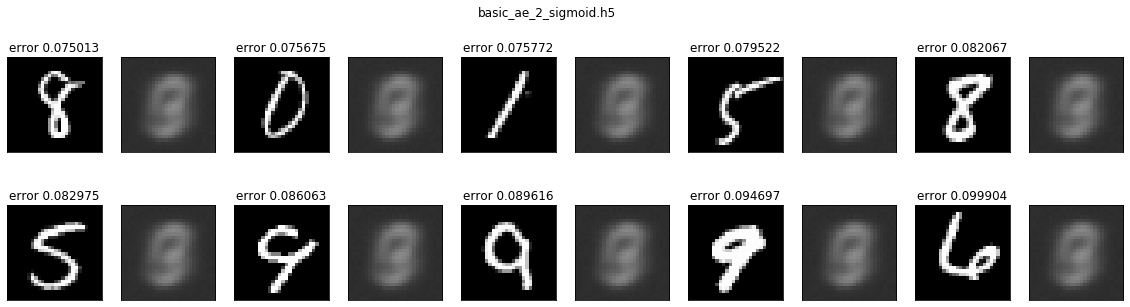

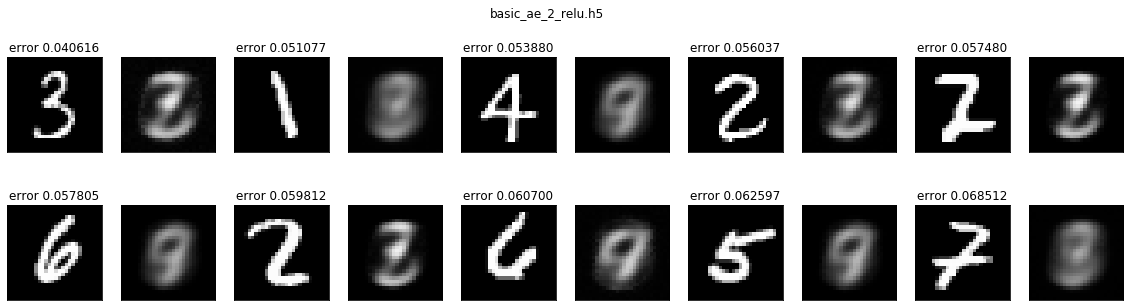

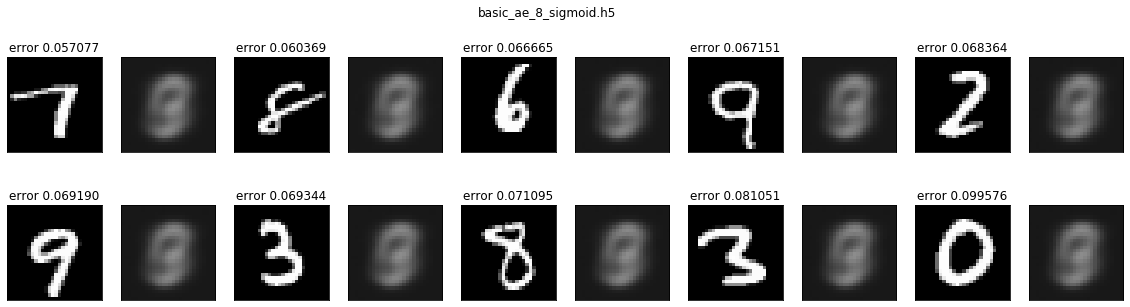

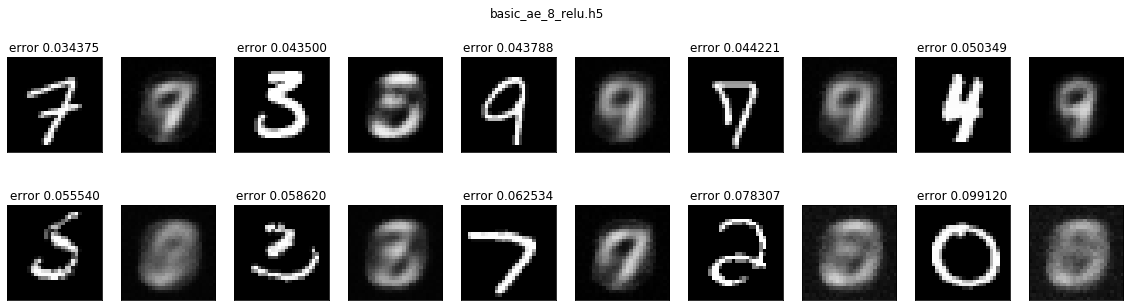

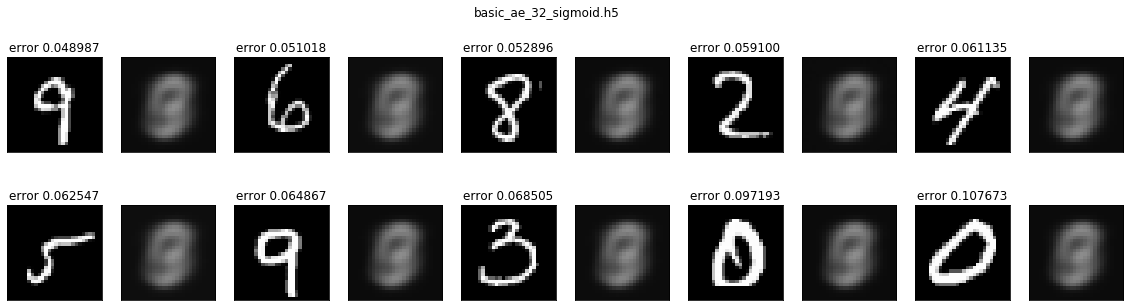

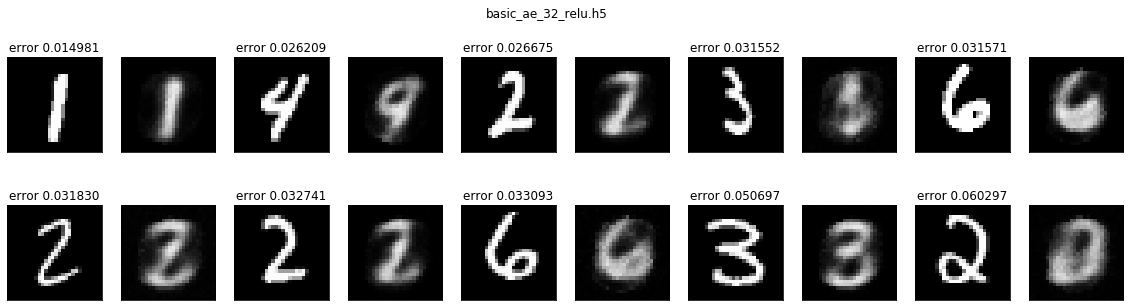

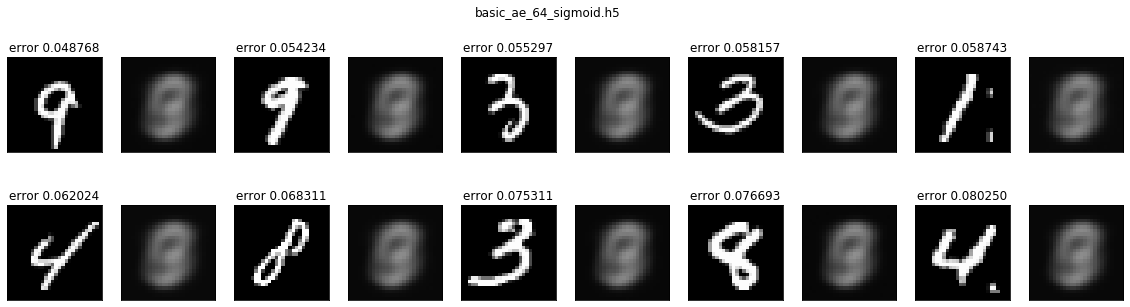

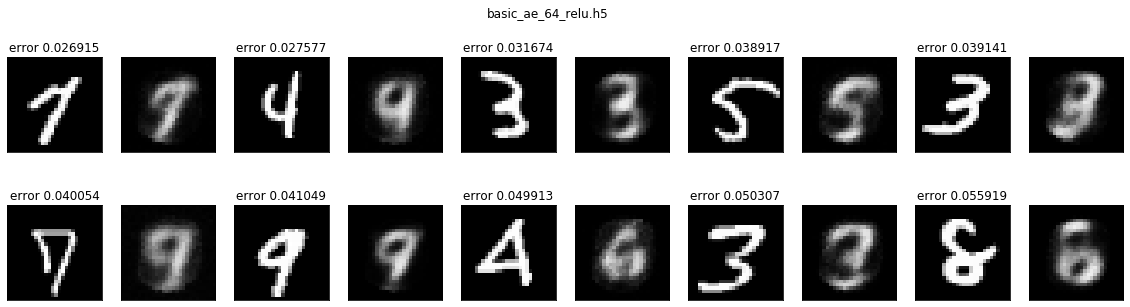

In [9]:
# Get errors
for dim in DIMS:
    for activ in ('sigmoid','relu'):
        name = "basic_ae_%d_%s.h5"%(dim,activ)
        ae = keras.models.load_model(name)
        idxs = np.arange(x_test_f.shape[0])
        np.random.shuffle(idxs)
        N = 10
        idxs = idxs[:N]
        reals = x_test_f[idxs]
        preds = ae.predict(reals)
        errors = np.mean((reals-preds)**2,axis=1)
        # Sort in increasing error
        trf = np.argsort(errors)
        reals = reals[trf]
        preds = preds[trf]
        errors = errors[trf]
        #
        plt.figure(figsize=(2*N,5))
        plt.suptitle(name)
        for i in range(N):
            ax = plt.subplot(2,N,2*i+1)
            ax.set_title("error %f"%errors[i])
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(reals[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
            ax = plt.subplot(2,N,2*i+2)
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
        plt.show()


---

c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. **Mida el error de pruebas** obtenido construyendo este clasificador sobre la data reducida a través del *autoencoder* comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios **¿La representación generada por el *autoencoder* logra generalizar?**

In [10]:
# Get errors
for dim in DIMS:
    # PCA
    pca = sklearn.decomposition.PCA(n_components=dim)
    pca.fit(x_tra_f)
    pca_train = pca.transform(x_tra_f)
    #
    clf = sklearn.neighbors.KNeighborsClassifier(10)
    clf.fit(pca_train,y_tra)
    #
    start = time.time()
    pca_test = pca.transform(x_test_f)
    score = clf.score(pca_test,y_test)
    elapsed = time.time()-start
    #
    print('%3ddims %-15s  score:%.3f   time:%8.3f[s]'%(
        dim,'pca',score,elapsed))
    #
    for activ in ('sigmoid','relu'):
        # AUTOENCODER
        nameae = "basic_ae_%d_%s.h5"%(dim,activ)
        name = "basic_e_%d_%s.h5"%(dim,activ)
        enc = keras.models.load_model(name)
        enc_train = enc.predict(x_tra_f)
        clf = sklearn.neighbors.KNeighborsClassifier(10)
        clf.fit(enc_train,y_tra)
        #
        start = time.time()
        enc_test = enc.predict(x_test_f)
        score = clf.score(enc_test,y_test)
        elapsed = time.time()-start
        #
        print('%3ddims %-15s  score:%.3f   time:%8.3f[s]  recons:%.3f'%(
        dim,'ae_'+activ,score,elapsed,test_recerr[nameae]))

  2dims pca              score:0.436   time:   0.063[s]
  2dims ae_sigmoid       score:0.208   time:   0.315[s]  recons:0.087
  2dims ae_relu          score:0.325   time:   0.315[s]  recons:0.063
  8dims pca              score:0.903   time:   1.217[s]
  8dims ae_sigmoid       score:0.465   time:   1.219[s]  recons:0.072
  8dims ae_relu          score:0.812   time:   0.768[s]  recons:0.053
 32dims pca              score:0.974   time:  24.016[s]
 32dims ae_sigmoid       score:0.799   time:  14.249[s]  recons:0.069
 32dims ae_relu          score:0.928   time:   8.126[s]  recons:0.041
 64dims pca              score:0.973   time:  54.735[s]
 64dims ae_sigmoid       score:0.874   time:  24.645[s]  recons:0.068
 64dims ae_relu          score:0.945   time:  22.185[s]  recons:0.037


---

d) Modifique el *autoencoder* básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. **Demuestre experimentalmente** que este *autoencoder* puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades ($L \in [2,4]$). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

In [11]:
def deep_autoencoder(dims,nneurons=(1000,500,250)):
    # Layers
    input_img = keras.layers.Input(shape=(784,))
    enc_layers = [keras.layers.Dense(x,activation='relu') for x in nneurons]
    enc_layers.append(keras.layers.Dense(dims,activation='relu'))
    dec_layers = [keras.layers.Dense(x,activation='relu') for x in nneurons[::-1]]
    dec_layers.append(keras.layers.Dense(784,activation='sigmoid'))
    # Encoding
    front = input_img
    for la in enc_layers:
        front = la(front)
    encoder = front
    # Decoding
    for la in dec_layers:
        front = la(front)
    # Whole Autoencoder
    autoenc = keras.models.Model(inputs=input_img,outputs=front)
    # Encoder
    encoder = keras.models.Model(inputs=input_img,outputs=encoder)
    # Decoder
    encoded_input = keras.layers.Input(shape=(dims,))
    front = encoded_input
    for la in dec_layers:
        front = la(front)
    decoder = keras.models.Model(inputs=encoded_input,outputs=front)
    # Return the 3 models
    return autoenc,encoder,decoder

In [12]:
ARCHS = {'2la':[500,250],'4la':[1000,750,500,250]}
DIMS2 = [2,4,8,16]

In [13]:
# ---@> Train models:
for dim in DIMS2:
    for idc in ARCHS:
        neurons= ARCHS[idc]
        name = "deep_%s_ae_%d.h5"%(idc,dim)
        ename = "deep_%s_e_%d.h5"%(idc,dim)
        dname = "deep_%s_d_%d.h5"%(idc,dim)
        model_ae,model_e,model_d = deep_autoencoder(dim,neurons)
        model_ae.compile(optimizer=keras.optimizers.SGD(lr=1.0),loss='mse')
        model_ae.fit(x_tra_f,x_tra_f,epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE)
        model_ae.save(name)
        #
        model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_e.save(ename)
        model_d.save(dname)

Epoch 1/80
55000/55000 [==============================] - 4s 76us/step - loss: 0.1009
Epoch 2/80
55000/55000 [==============================] - 4s 66us/step - loss: 0.0668
Epoch 3/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0653
Epoch 4/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0634
Epoch 5/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0598
Epoch 6/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0588
Epoch 7/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0581
Epoch 8/80
55000/55000 [==============================] - 4s 64us/step - loss: 0.0576
Epoch 9/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0571
Epoch 10/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0567
Epoch 11/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0562
Epoch 12/80
55000/55000 [===========================

55000/55000 [==============================] - 9s 173us/step - loss: 0.0508
Epoch 16/80
55000/55000 [==============================] - 9s 173us/step - loss: 0.0503
Epoch 17/80
55000/55000 [==============================] - 9s 171us/step - loss: 0.0498
Epoch 18/80
55000/55000 [==============================] - 9s 171us/step - loss: 0.0494
Epoch 19/80
55000/55000 [==============================] - 9s 172us/step - loss: 0.0490
Epoch 20/80
55000/55000 [==============================] - 9s 171us/step - loss: 0.0486
Epoch 21/80
55000/55000 [==============================] - 9s 172us/step - loss: 0.0482
Epoch 22/80
55000/55000 [==============================] - 10s 173us/step - loss: 0.0478
Epoch 23/80
55000/55000 [==============================] - 9s 173us/step - loss: 0.0473
Epoch 24/80
55000/55000 [==============================] - 9s 173us/step - loss: 0.0470
Epoch 25/80
55000/55000 [==============================] - 9s 173us/step - loss: 0.0467
Epoch 26/80
55000/55000 [==================

55000/55000 [==============================] - 4s 68us/step - loss: 0.0393
Epoch 29/80
55000/55000 [==============================] - 4s 68us/step - loss: 0.0390
Epoch 30/80
55000/55000 [==============================] - 4s 67us/step - loss: 0.0388
Epoch 31/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0386
Epoch 32/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0383
Epoch 33/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0381
Epoch 34/80
55000/55000 [==============================] - 4s 66us/step - loss: 0.0379
Epoch 35/80
55000/55000 [==============================] - 4s 65us/step - loss: 0.0377
Epoch 36/80
55000/55000 [==============================] - 4s 64us/step - loss: 0.0375
Epoch 37/80
55000/55000 [==============================] - 4s 66us/step - loss: 0.0374
Epoch 38/80
55000/55000 [==============================] - 4s 66us/step - loss: 0.0372
Epoch 39/80
55000/55000 [==============================

55000/55000 [==============================] - 10s 173us/step - loss: 0.0375
Epoch 42/80
55000/55000 [==============================] - 9s 173us/step - loss: 0.0373
Epoch 43/80
55000/55000 [==============================] - 9s 173us/step - loss: 0.0372
Epoch 44/80
55000/55000 [==============================] - 10s 173us/step - loss: 0.0369
Epoch 45/80
55000/55000 [==============================] - 10s 173us/step - loss: 0.0368
Epoch 46/80
55000/55000 [==============================] - 10s 174us/step - loss: 0.0366
Epoch 47/80
55000/55000 [==============================] - 10s 174us/step - loss: 0.0364
Epoch 48/80
55000/55000 [==============================] - 10s 175us/step - loss: 0.0363
Epoch 49/80
55000/55000 [==============================] - 10s 176us/step - loss: 0.0361
Epoch 50/80
55000/55000 [==============================] - 10s 173us/step - loss: 0.0360
Epoch 51/80
55000/55000 [==============================] - 10s 174us/step - loss: 0.0358
Epoch 52/80
55000/55000 [==========

55000/55000 [==============================] - 4s 68us/step - loss: 0.0276
Epoch 55/80
55000/55000 [==============================] - 4s 69us/step - loss: 0.0275
Epoch 56/80
55000/55000 [==============================] - 4s 68us/step - loss: 0.0274
Epoch 57/80
55000/55000 [==============================] - 4s 67us/step - loss: 0.0273
Epoch 58/80
55000/55000 [==============================] - 4s 68us/step - loss: 0.0272
Epoch 59/80
55000/55000 [==============================] - 4s 66us/step - loss: 0.0271
Epoch 60/80
55000/55000 [==============================] - 4s 67us/step - loss: 0.0270
Epoch 61/80
55000/55000 [==============================] - 4s 66us/step - loss: 0.0269
Epoch 62/80
55000/55000 [==============================] - 4s 66us/step - loss: 0.0269
Epoch 63/80
55000/55000 [==============================] - 4s 67us/step - loss: 0.0268
Epoch 64/80
55000/55000 [==============================] - 4s 66us/step - loss: 0.0268
Epoch 65/80
55000/55000 [==============================

Epoch 67/80
55000/55000 [==============================] - 29s 525us/step - loss: 0.01890s - loss:
Epoch 68/80
55000/55000 [==============================] - 29s 524us/step - loss: 0.0188
Epoch 69/80
55000/55000 [==============================] - 29s 526us/step - loss: 0.0187
Epoch 70/80
55000/55000 [==============================] - 29s 521us/step - loss: 0.0187
Epoch 71/80
55000/55000 [==============================] - 29s 525us/step - loss: 0.0186
Epoch 72/80
55000/55000 [==============================] - 28s 507us/step - loss: 0.0186
Epoch 73/80
55000/55000 [==============================] - 27s 491us/step - loss: 0.0185
Epoch 74/80
55000/55000 [==============================] - 28s 500us/step - loss: 0.0184
Epoch 75/80
55000/55000 [==============================] - 28s 507us/step - loss: 0.0183
Epoch 76/80
55000/55000 [==============================] - 28s 508us/step - loss: 0.0183
Epoch 77/80
55000/55000 [==============================] - 28s 500us/step - loss: 0.0182
Epoch 78/80

55000/55000 [==============================] - 12s 224us/step - loss: 0.0140
Epoch 80/80
55000/55000 [==============================] - 13s 230us/step - loss: 0.0140
Epoch 1/80
55000/55000 [==============================] - 29s 532us/step - loss: 0.0984
Epoch 2/80
55000/55000 [==============================] - 27s 493us/step - loss: 0.0649
Epoch 3/80
55000/55000 [==============================] - 28s 503us/step - loss: 0.0639
Epoch 4/80
55000/55000 [==============================] - 27s 492us/step - loss: 0.0632
Epoch 5/80
55000/55000 [==============================] - 27s 496us/step - loss: 0.0611
Epoch 6/80
55000/55000 [==============================] - 28s 511us/step - loss: 0.0580
Epoch 7/80
55000/55000 [==============================] - 15s 276us/step - loss: 0.0532
Epoch 8/80
55000/55000 [==============================] - 15s 272us/step - loss: 0.0476
Epoch 9/80
 1408/55000 [..............................] - ETA: 3:29 - loss: 0.0447

/home/fcasas/Music/p36env/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.418657). Check your callbacks.
  % delta_t_median)
/home/fcasas/Music/p36env/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210315). Check your callbacks.
  % delta_t_median)


55000/55000 [==============================] - 14s 248us/step - loss: 0.0434
Epoch 10/80
55000/55000 [==============================] - 8s 146us/step - loss: 0.0405
Epoch 11/80
 1408/55000 [..............................] - ETA: 25s - loss: 0.0386

/home/fcasas/Music/p36env/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103576). Check your callbacks.
  % delta_t_median)


55000/55000 [==============================] - 8s 153us/step - loss: 0.0376
Epoch 12/80
55000/55000 [==============================] - 10s 174us/step - loss: 0.0357
Epoch 13/80
55000/55000 [==============================] - 22s 397us/step - loss: 0.0342
Epoch 14/80
55000/55000 [==============================] - 21s 381us/step - loss: 0.0330
Epoch 15/80
55000/55000 [==============================] - 21s 389us/step - loss: 0.0319
Epoch 16/80
55000/55000 [==============================] - 22s 398us/step - loss: 0.0308
Epoch 17/80
55000/55000 [==============================] - 22s 397us/step - loss: 0.0299
Epoch 18/80
55000/55000 [==============================] - 22s 394us/step - loss: 0.0291
Epoch 19/80
55000/55000 [==============================] - 22s 392us/step - loss: 0.0282
Epoch 20/80
55000/55000 [==============================] - 14s 250us/step - loss: 0.0271
Epoch 21/80
55000/55000 [==============================] - 8s 151us/step - loss: 0.0262
Epoch 22/80
55000/55000 [==========

In [14]:
for dim in DIMS2:
    # PCA
    pca = sklearn.decomposition.PCA(n_components=dim)
    pca.fit(x_tra_f)
    pca_tra = pca.transform(x_tra_f)
    pca_test = pca.transform(x_test_f)
    clf = sklearn.neighbors.KNeighborsClassifier(10)
    clf.fit(pca_tra,y_tra)
    score = clf.score(pca_test,y_test)
    #
    print("%2ddims %-30s  score:%.3f"%(dim,'pca',score))
    #
    for idc in sorted(list(ARCHS)):
        name = "deep_%s_ae_%d.h5"%(idc,dim)
        ename = "deep_%s_e_%d.h5"%(idc,dim)
        autoenc = keras.models.load_model(name)
        encoder = keras.models.load_model(ename)
        # Reconstruction error
        x_test_pred_f = autoenc.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        recon_error = np.mean(np.mean((x_test_pred_f-x_test_f)**2,axis=1))
        # Clasification error:
        x_tra_enc = encoder.predict(x_tra_f,batch_size=REGULAR_BATCH_SIZE)
        x_test_enc = encoder.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        clf = sklearn.neighbors.KNeighborsClassifier(10)
        clf.fit(x_tra_enc,y_tra)
        score = clf.score(x_test_enc,y_test)
        print("%2ddims %-30s  score:%.3f  recons:%.3f"%(dim,name,score,recon_error))

 2dims pca                             score:0.436
 2dims deep_2la_ae_2.h5                score:0.639  recons:0.046
 2dims deep_4la_ae_2.h5                score:0.787  recons:0.039
 4dims pca                             score:0.645
 4dims deep_2la_ae_4.h5                score:0.816  recons:0.033
 4dims deep_4la_ae_4.h5                score:0.841  recons:0.033
 8dims pca                             score:0.903
 8dims deep_2la_ae_8.h5                score:0.898  recons:0.025
 8dims deep_4la_ae_8.h5                score:0.940  recons:0.018
16dims pca                             score:0.961
16dims deep_2la_ae_16.h5               score:0.959  recons:0.014
16dims deep_4la_ae_16.h5               score:0.963  recons:0.013


---

e) Elija algunas de las representaciones aprendidas anteriormente ($d>2$) y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. **Compare cualitativamente el resultado con aquel obtenido usando PCA** con el mismo número de componentes ($d>2$). Finalmente **grafique una representación** generada por un autoencoder directamente ($d=2$), comente.

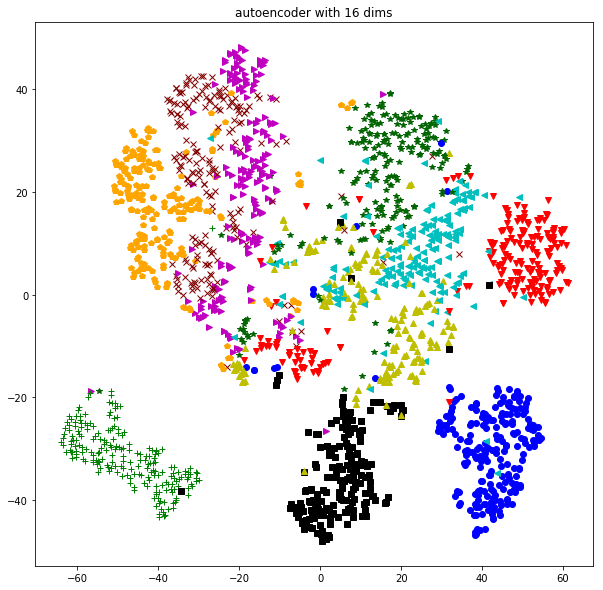

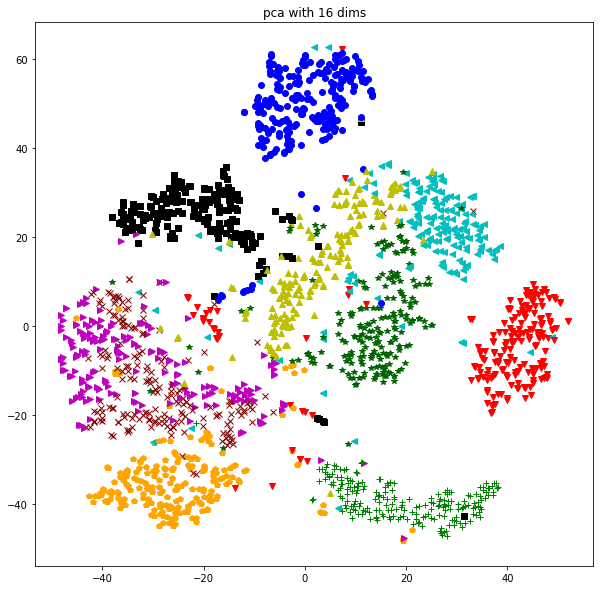

In [15]:
dims = 16
encoder = keras.models.load_model("deep_2la_e_%d.h5"%dims)

nplot = 2000
for t in (0,1):
    if t==0:
        enc_tra = encoder.predict(x_tra_f[:nplot])
    else:
        pca = sklearn.decomposition.PCA(n_components=dim)
        pca.fit(x_tra_f)
        pca_train = pca.transform(x_tra_f)
        enc_tra = pca_train[:nplot]
    #
    model = sklearn.manifold.TSNE(n_components=2,random_state=0)
    enc_tra = model.fit_transform(enc_tra)

    # Plot with tnse:
    plt.figure(figsize=(10,10))
    plt.title(("autoencoder" if t==0 else "pca")+" with %d dims"%dims)
    colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
    markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
    for idx in range(nplot):
        label = y_tra[idx]
        line = plt.plot(enc_tra[idx][0],enc_tra[idx][1],
            color=colors[label], marker=markers[label], markersize=6)
    plt.show()

---

f) Cuando el problema se torna más difícil es necesario complejizar el modelo. Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el *Encoder* y capas con **convoluciones transpuesta** en el *Decoder*, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.

In [16]:
def conv_autoencoder(dims):
    input_img = keras.layers.Input(shape=(28,28,1))
    front = input_img
    front = keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.MaxPooling2D((2,2))(front)
    front = keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.MaxPooling2D((2,2))(front)
    front = keras.layers.Flatten()(front)
    front = keras.layers.Dense(dims)(front)
    encoded = front
    #
    front = keras.layers.Dense(7*7*32)(front)
    front = keras.layers.Reshape((7,7,32))(front)
    front = keras.layers.UpSampling2D((2,2))(front)
    front = keras.layers.Conv2DTranspose(16,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.UpSampling2D((2,2))(front)
    front = keras.layers.Conv2DTranspose(1,(3,3),activation='relu',padding='same')(front)
    decoded = front
    #
    autoenc = keras.models.Model(inputs=input_img,outputs=decoded)
    encoder = keras.models.Model(inputs=input_img,outputs=encoded)
    return autoenc,encoder

In [17]:
convae,convenc = conv_autoencoder(8)
convae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 8)                 12552     
__________

In [18]:
# ---@> Train models:
for dim in DIMS:
    convae,convenc = conv_autoencoder(dim)
    convae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
    x_tra_im = np.reshape(x_tra_f,(x_tra_f.shape[0],28,28,1))
    convae.fit(x_tra_im,x_tra_im,epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE)
    #
    name = "conv_%s_ae_%d.h5"%(idc,dim)
    ename = "conv_%s_e_%d.h5"%(idc,dim)
    convenc.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
    convae.save(name)
    convenc.save(ename)

Epoch 1/80
55000/55000 [==============================] - 25s 450us/step - loss: 0.0672
Epoch 2/80
55000/55000 [==============================] - 14s 250us/step - loss: 0.0588
Epoch 3/80
55000/55000 [==============================] - 14s 246us/step - loss: 0.0564
Epoch 4/80
55000/55000 [==============================] - 13s 242us/step - loss: 0.0559
Epoch 5/80
55000/55000 [==============================] - 14s 249us/step - loss: 0.0555
Epoch 6/80
55000/55000 [==============================] - 13s 242us/step - loss: 0.0552
Epoch 7/80
55000/55000 [==============================] - 14s 251us/step - loss: 0.0549
Epoch 8/80
55000/55000 [==============================] - 14s 257us/step - loss: 0.0545
Epoch 9/80
55000/55000 [==============================] - 14s 246us/step - loss: 0.0542
Epoch 10/80
55000/55000 [==============================] - 14s 246us/step - loss: 0.0538
Epoch 11/80
55000/55000 [==============================] - 13s 244us/step - loss: 0.0535
Epoch 12/80
55000/55000 [=====

55000/55000 [==============================] - 13s 236us/step - loss: 0.0293
Epoch 14/80
55000/55000 [==============================] - 13s 239us/step - loss: 0.0289
Epoch 15/80
55000/55000 [==============================] - 13s 237us/step - loss: 0.0285
Epoch 16/80
55000/55000 [==============================] - 13s 243us/step - loss: 0.0281
Epoch 17/80
55000/55000 [==============================] - 15s 272us/step - loss: 0.0278
Epoch 18/80
55000/55000 [==============================] - 15s 267us/step - loss: 0.0275
Epoch 19/80
55000/55000 [==============================] - 14s 249us/step - loss: 0.0273
Epoch 20/80
55000/55000 [==============================] - 13s 235us/step - loss: 0.0271
Epoch 21/80
55000/55000 [==============================] - 13s 234us/step - loss: 0.0268
Epoch 22/80
55000/55000 [==============================] - 13s 234us/step - loss: 0.0266
Epoch 23/80
55000/55000 [==============================] - 13s 234us/step - loss: 0.0265
Epoch 24/80
55000/55000 [========

55000/55000 [==============================] - 27s 486us/step - loss: 0.0122
Epoch 26/80
55000/55000 [==============================] - 14s 258us/step - loss: 0.0120
Epoch 27/80
55000/55000 [==============================] - 29s 528us/step - loss: 0.0118
Epoch 28/80
55000/55000 [==============================] - 37s 664us/step - loss: 0.0117
Epoch 29/80
55000/55000 [==============================] - 41s 737us/step - loss: 0.0115
Epoch 30/80
55000/55000 [==============================] - 38s 693us/step - loss: 0.0114
Epoch 31/80
55000/55000 [==============================] - 46s 843us/step - loss: 0.0112
Epoch 32/80
55000/55000 [==============================] - 53s 956us/step - loss: 0.0111
Epoch 33/80
55000/55000 [==============================] - 54s 985us/step - loss: 0.0110
Epoch 34/80
55000/55000 [==============================] - 43s 777us/step - loss: 0.0108
Epoch 35/80
55000/55000 [==============================] - 49s 888us/step - loss: 0.0107
Epoch 36/80
55000/55000 [========

55000/55000 [==============================] - 36s 659us/step - loss: 0.0090
Epoch 38/80
55000/55000 [==============================] - 36s 663us/step - loss: 0.0089
Epoch 39/80
55000/55000 [==============================] - 35s 637us/step - loss: 0.0088
Epoch 40/80
55000/55000 [==============================] - 27s 485us/step - loss: 0.0087
Epoch 41/80
55000/55000 [==============================] - 25s 448us/step - loss: 0.0087
Epoch 42/80
55000/55000 [==============================] - 25s 450us/step - loss: 0.0086
Epoch 43/80
55000/55000 [==============================] - 34s 617us/step - loss: 0.0085
Epoch 44/80
55000/55000 [==============================] - 37s 681us/step - loss: 0.0085
Epoch 45/80
55000/55000 [==============================] - 38s 682us/step - loss: 0.0084
Epoch 46/80
55000/55000 [==============================] - 36s 654us/step - loss: 0.0083
Epoch 47/80
55000/55000 [==============================] - 40s 722us/step - loss: 0.0083
Epoch 48/80
55000/55000 [========

In [19]:
for dim in DIMS:
    name = "conv_%s_ae_%d.h5"%(idc,dim)
    ename = "conv_%s_e_%d.h5"%(idc,dim)
    convae = keras.models.load_model(name)
    x_tra_im =  np.reshape(x_tra_f,(x_tra_f.shape[0],28,28,1))
    x_test_im =  np.reshape(x_test_f,(x_test_f.shape[0],28,28,1))
    
    x_pred_tra_im = convae.predict(x_tra_im,batch_size=REGULAR_BATCH_SIZE)
    x_pred_test_im = convae.predict(x_test_im,batch_size=REGULAR_BATCH_SIZE)
    
    
    error_tra = np.mean((x_pred_tra_im-x_tra_im)**2)
    error_test = np.mean((x_pred_test_im-x_test_im)**2)
    print("%-30s  tr_err:%.7f  te_err:%.7f"%(name,error_tra,error_test))
    
# NOTE: Classification performance was not requested ??

conv_4la_ae_2.h5                tr_err:0.0481567  te_err:0.0478330
conv_4la_ae_8.h5                tr_err:0.0224987  te_err:0.0222410
conv_4la_ae_32.h5               tr_err:0.0084397  te_err:0.0082557
conv_4la_ae_64.h5               tr_err:0.0069846  te_err:0.0068221


---

### 2.2 Denoising

Como se ha discutido en clases, un *denoising autoencoder* (dAE)[[4]](#refs) es escencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

---

a) **Genere artificialmente una versión corrupta de las imágenes en MNIST** utilizando el siguiente modelo de ruido (masking noise): si $ x \in {\rm I\!R}^d $ es una de las imágenes originales, la versión ruidosa $\tilde{x}$ se obtiene como $\tilde{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.

In [20]:
def noisy(data,p=0.1):
    return data * np.random.binomial(n=1,p=p,size=data.shape)

In [21]:
noisy_x_tra = noisy(x_tra_f)
noisy_x_val = noisy(x_val_f)
noisy_x_test = noisy(x_test_f)

---

b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. **Experimente diferentes valores de *p* en el rango (0, 1).**

In [22]:
DIMS3 = [16,32]
PVALS = (0.10,0.25,0.50,0.75)

noisy_x_tra = {}
noisy_x_val = {}
noisy_x_test = {}

for p in PVALS:
    noisy_x_tra[p] = noisy(x_tra_f,p)
    noisy_x_val[p] = noisy(x_val_f,p)
    noisy_x_test[p] = noisy(x_test_f,p)

In [23]:
# ---@> Train models:
for dim in DIMS3:
    for p in PVALS:
        model_ae,model_e,model_d = autoencoder(dim,"relu")
        model_ae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_ae.fit(noisy_x_tra[p],x_tra_f,
                    epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE,
                    validation_data=(x_val_f,x_val_f))
        model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        #
        ename = "denoi_e_%d_%.3f.h5"%(dim,p)
        dname = "denoi_d_%d_%.3f.h5"%(dim,p)
        name = "denoi_ae_%d_%.3f.h5"%(dim,p)
        model_e.save(ename)
        model_d.save(dname)
        model_ae.save(name)

Train on 55000 samples, validate on 5000 samples
Epoch 1/80
55000/55000 [==============================] - 27s 489us/step - loss: 0.2303 - val_loss: 0.2294
Epoch 2/80
55000/55000 [==============================] - 7s 119us/step - loss: 0.2279 - val_loss: 0.2266
Epoch 3/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.2255 - val_loss: 0.2236
Epoch 4/80
55000/55000 [==============================] - 5s 99us/step - loss: 0.2231 - val_loss: 0.2204
Epoch 5/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.2206 - val_loss: 0.2166
Epoch 6/80
55000/55000 [==============================] - 5s 85us/step - loss: 0.2178 - val_loss: 0.2115
Epoch 7/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.2145 - val_loss: 0.2040
Epoch 8/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.2100 - val_loss: 0.1924
Epoch 9/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.2036 - val_loss: 0.1745
Ep

55000/55000 [==============================] - 2s 32us/step - loss: 0.0679 - val_loss: 0.0772
Epoch 78/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0679 - val_loss: 0.0772
Epoch 79/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0679 - val_loss: 0.0771
Epoch 80/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0679 - val_loss: 0.0771
Train on 55000 samples, validate on 5000 samples
Epoch 1/80
55000/55000 [==============================] - 3s 59us/step - loss: 0.2302 - val_loss: 0.2285
Epoch 2/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.2276 - val_loss: 0.2251
Epoch 3/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.2247 - val_loss: 0.2201
Epoch 4/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.2209 - val_loss: 0.2110
Epoch 5/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.2145 - val_loss: 0.1919
Epoch 6/80
550

55000/55000 [==============================] - 2s 33us/step - loss: 0.0680 - val_loss: 0.0737
Epoch 75/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0679 - val_loss: 0.0736
Epoch 76/80
55000/55000 [==============================] - 2s 35us/step - loss: 0.0679 - val_loss: 0.0735
Epoch 77/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0678 - val_loss: 0.0733
Epoch 78/80
55000/55000 [==============================] - 2s 36us/step - loss: 0.0678 - val_loss: 0.0732
Epoch 79/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0677 - val_loss: 0.0731
Epoch 80/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0677 - val_loss: 0.0729
Train on 55000 samples, validate on 5000 samples
Epoch 1/80
55000/55000 [==============================] - 4s 78us/step - loss: 0.2299 - val_loss: 0.2273
Epoch 2/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.2252 - val_loss: 0.2169
Epoch 3/80


55000/55000 [==============================] - 2s 38us/step - loss: 0.0589 - val_loss: 0.0566
Epoch 72/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0586 - val_loss: 0.0563
Epoch 73/80
55000/55000 [==============================] - 2s 35us/step - loss: 0.0584 - val_loss: 0.0560
Epoch 74/80
55000/55000 [==============================] - 2s 42us/step - loss: 0.0581 - val_loss: 0.0557
Epoch 75/80
55000/55000 [==============================] - 2s 36us/step - loss: 0.0578 - val_loss: 0.0554
Epoch 76/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0575 - val_loss: 0.0551
Epoch 77/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0573 - val_loss: 0.0548
Epoch 78/80
55000/55000 [==============================] - 2s 37us/step - loss: 0.0570 - val_loss: 0.0546
Epoch 79/80
55000/55000 [==============================] - 2s 43us/step - loss: 0.0567 - val_loss: 0.0544
Epoch 80/80
55000/55000 [==============================] -

55000/55000 [==============================] - 2s 34us/step - loss: 0.0520 - val_loss: 0.0501
Epoch 69/80
55000/55000 [==============================] - 2s 36us/step - loss: 0.0517 - val_loss: 0.0498
Epoch 70/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0514 - val_loss: 0.0496
Epoch 71/80
55000/55000 [==============================] - 2s 31us/step - loss: 0.0512 - val_loss: 0.0493
Epoch 72/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0509 - val_loss: 0.0491
Epoch 73/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0507 - val_loss: 0.0488
Epoch 74/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0504 - val_loss: 0.0486
Epoch 75/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0502 - val_loss: 0.0484
Epoch 76/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0500 - val_loss: 0.0482
Epoch 77/80
55000/55000 [==============================] -

55000/55000 [==============================] - 2s 35us/step - loss: 0.0681 - val_loss: 0.0777
Epoch 66/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0680 - val_loss: 0.0776
Epoch 67/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0680 - val_loss: 0.0776
Epoch 68/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0680 - val_loss: 0.0775
Epoch 69/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0680 - val_loss: 0.0775
Epoch 70/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0680 - val_loss: 0.0774
Epoch 71/80
55000/55000 [==============================] - 2s 35us/step - loss: 0.0680 - val_loss: 0.0774
Epoch 72/80
55000/55000 [==============================] - 2s 36us/step - loss: 0.0680 - val_loss: 0.0773
Epoch 73/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0679 - val_loss: 0.0773
Epoch 74/80
55000/55000 [==============================] -

55000/55000 [==============================] - 2s 32us/step - loss: 0.0679 - val_loss: 0.0731
Epoch 63/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0678 - val_loss: 0.0730
Epoch 64/80
55000/55000 [==============================] - 2s 35us/step - loss: 0.0678 - val_loss: 0.0728
Epoch 65/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0677 - val_loss: 0.0726
Epoch 66/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0676 - val_loss: 0.0725
Epoch 67/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0676 - val_loss: 0.0723
Epoch 68/80
55000/55000 [==============================] - 2s 36us/step - loss: 0.0675 - val_loss: 0.0721
Epoch 69/80
55000/55000 [==============================] - 2s 38us/step - loss: 0.0674 - val_loss: 0.0720
Epoch 70/80
55000/55000 [==============================] - 2s 32us/step - loss: 0.0674 - val_loss: 0.0718
Epoch 71/80
55000/55000 [==============================] -

55000/55000 [==============================] - 3s 51us/step - loss: 0.0615 - val_loss: 0.0591
Epoch 60/80
55000/55000 [==============================] - 3s 51us/step - loss: 0.0611 - val_loss: 0.0586
Epoch 61/80
55000/55000 [==============================] - 3s 52us/step - loss: 0.0608 - val_loss: 0.0582
Epoch 62/80
55000/55000 [==============================] - 3s 52us/step - loss: 0.0605 - val_loss: 0.0578
Epoch 63/80
55000/55000 [==============================] - 3s 56us/step - loss: 0.0601 - val_loss: 0.0574
Epoch 64/80
55000/55000 [==============================] - 3s 47us/step - loss: 0.0598 - val_loss: 0.0570
Epoch 65/80
55000/55000 [==============================] - 3s 49us/step - loss: 0.0594 - val_loss: 0.0566
Epoch 66/80
55000/55000 [==============================] - 2s 43us/step - loss: 0.0591 - val_loss: 0.0562
Epoch 67/80
55000/55000 [==============================] - 3s 49us/step - loss: 0.0588 - val_loss: 0.0559
Epoch 68/80
55000/55000 [==============================] -

55000/55000 [==============================] - 2s 33us/step - loss: 0.0534 - val_loss: 0.0512
Epoch 57/80
55000/55000 [==============================] - 2s 36us/step - loss: 0.0531 - val_loss: 0.0508
Epoch 58/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0527 - val_loss: 0.0505
Epoch 59/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0524 - val_loss: 0.0502
Epoch 60/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0520 - val_loss: 0.0498
Epoch 61/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0517 - val_loss: 0.0495
Epoch 62/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0514 - val_loss: 0.0492
Epoch 63/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0511 - val_loss: 0.0488
Epoch 64/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0508 - val_loss: 0.0485
Epoch 65/80
55000/55000 [==============================] -

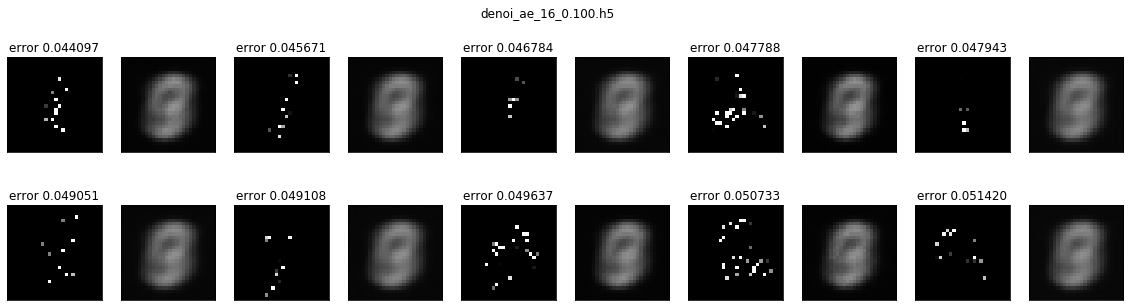

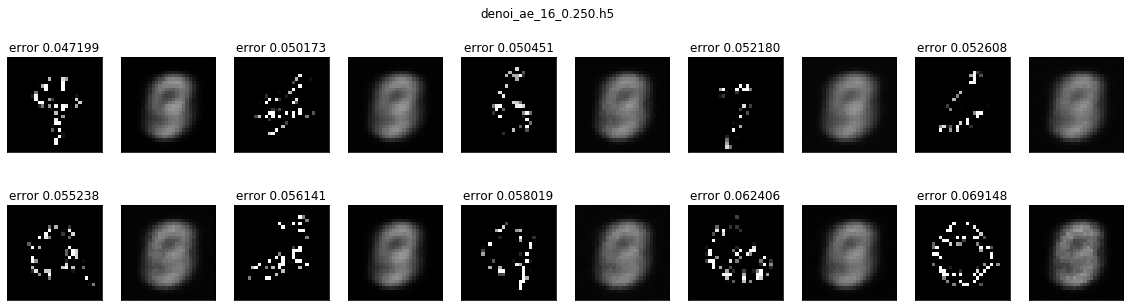

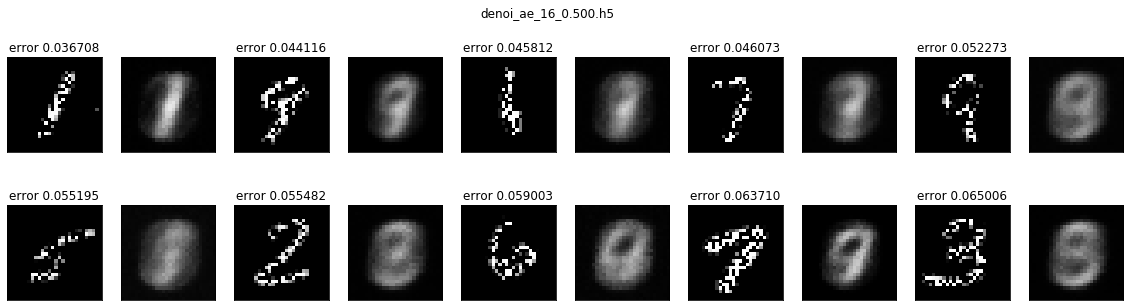

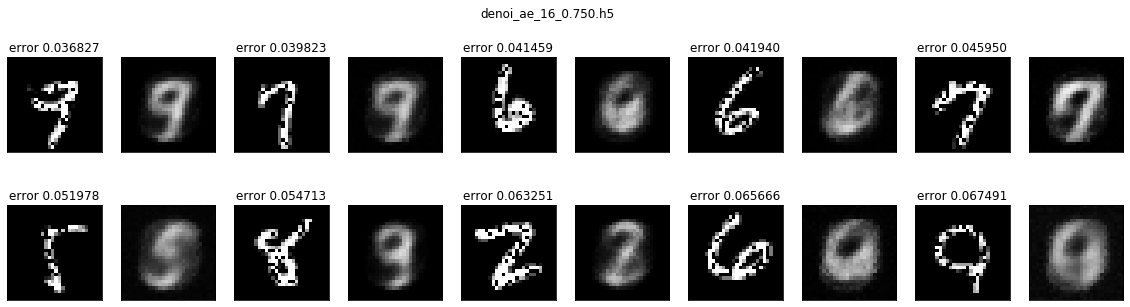

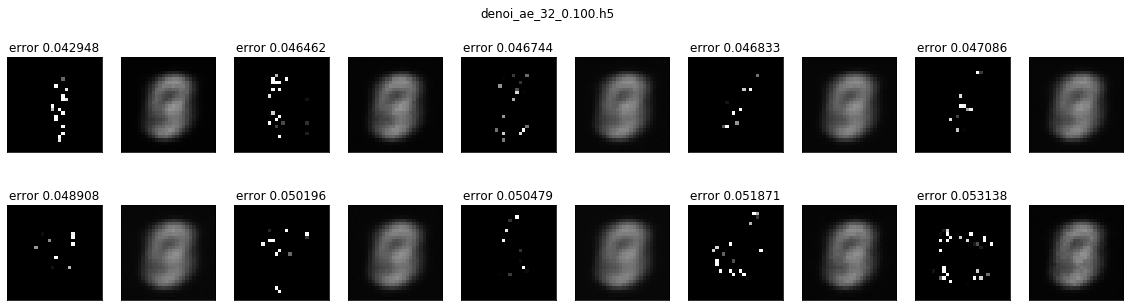

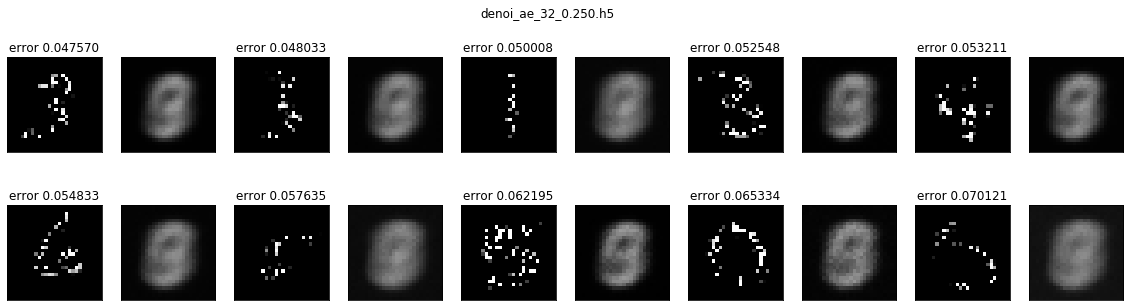

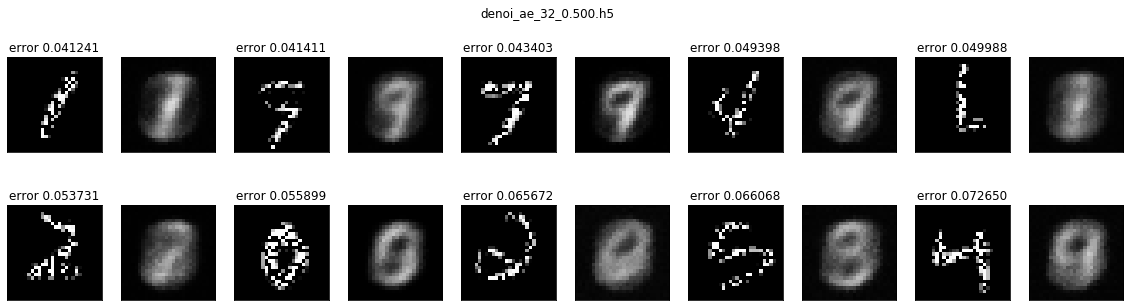

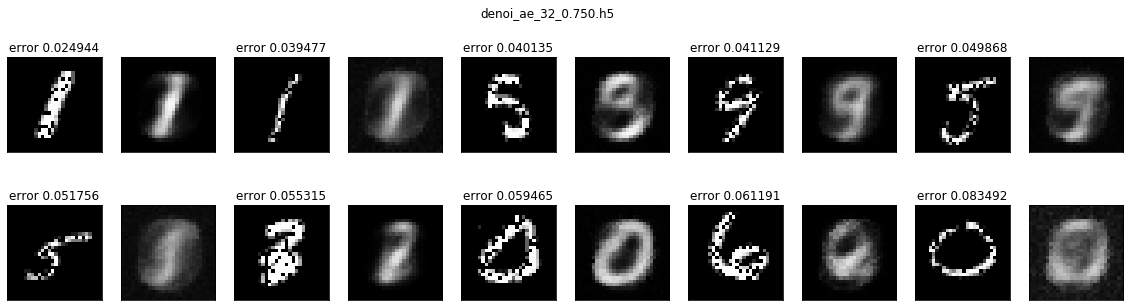

Errors:
	denoi_ae_16_0.100.h5 0.048
	denoi_ae_16_0.250.h5 0.054
	denoi_ae_16_0.500.h5 0.057
	denoi_ae_16_0.750.h5 0.052
	denoi_ae_32_0.100.h5 0.048
	denoi_ae_32_0.250.h5 0.054
	denoi_ae_32_0.500.h5 0.056
	denoi_ae_32_0.750.h5 0.051


In [24]:
total_errors = {}

for dim in DIMS3:
    for p in sorted(list(PVALS)):
        name = "denoi_ae_%d_%.3f.h5"%(dim,p)
        model_ae = keras.models.load_model(name)
        
        noisy_x_test_pred = model_ae.predict(noisy_x_test[p])
        total_error = np.mean((noisy_x_test_pred-noisy_x_test[p])**2)
        total_errors[name] = total_error
        
        idxs = np.arange(noisy_x_test[p].shape[0])
        np.random.shuffle(idxs)
        
        N = 10
        idxs = idxs[:N]
        reals = noisy_x_test[p][idxs]
        preds = model_ae.predict(reals)
        
        errors = np.mean((reals-preds)**2,axis=1)
        # Sort in increasing error
        trf = np.argsort(errors)
        reals = reals[trf]
        preds = preds[trf]
        errors = errors[trf]
        #
        plt.figure(figsize=(2*N,5))
        plt.suptitle(name)
        for i in range(N):
            ax = plt.subplot(2,N,2*i+1)
            ax.set_title("error %f"%errors[i])
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(reals[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
            ax = plt.subplot(2,N,2*i+2)
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
        plt.show()
print("Errors:")
for name in sorted(list(total_errors.keys())):
    print("\t%-20s %.3f"%(name,total_errors[name]))

---

c) Utilice la representación reducida, genera por el *denoising AE*, para **medir el desempeño en clasificación** (vı́a kNN como en la sección anterior). Comente.

In [25]:
for dim in DIMS3:
    for p in sorted(list(PVALS)):
        name = "denoi_ae_%d_%.3f.h5"%(dim,p)
        ename = "denoi_e_%d_%.3f.h5"%(dim,p)
        autoenc = keras.models.load_model(name)
        encoder = keras.models.load_model(ename)
        # Reconstruction error
        x_test_pred_f = autoenc.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        recon_error = np.mean(np.mean((x_test_pred_f-x_test_f)**2,axis=1))
        # Clasification error:
        x_tra_enc = encoder.predict(x_tra_f,batch_size=REGULAR_BATCH_SIZE)
        x_test_enc = encoder.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        clf = sklearn.neighbors.KNeighborsClassifier(10)
        clf.fit(x_tra_enc,y_tra)
        score = clf.score(x_test_enc,y_test)
        print("%2ddims %-30s  score:%.3f  recons:%.3f"%(dim,name,score,recon_error))

16dims denoi_ae_16_0.100.h5            score:0.782  recons:0.078
16dims denoi_ae_16_0.250.h5            score:0.789  recons:0.074
16dims denoi_ae_16_0.500.h5            score:0.862  recons:0.054
16dims denoi_ae_16_0.750.h5            score:0.885  recons:0.047
32dims denoi_ae_32_0.100.h5            score:0.880  recons:0.078
32dims denoi_ae_32_0.250.h5            score:0.884  recons:0.070
32dims denoi_ae_32_0.500.h5            score:0.900  recons:0.052
32dims denoi_ae_32_0.750.h5            score:0.921  recons:0.044


---

d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes.

In [26]:
@numba.jit
def creepy_noise(data,t=50):
    data = np.copy(data).reshape((data.shape[0],28,28))
    for i in range(data.shape[0]):
        for _ in range(t):
            d = random.randint(0,3)
            pos = random.randint(0,27)
            if d==0:
                data[i,pos,:-1] = np.copy(data[i,pos,1:])
            elif d==1:
                data[i,pos,1:] = np.copy(data[i,pos,:-1])
            elif d==2:
                data[i,:-1,pos] = np.copy(data[i,1:,pos])
            elif d==3:
                data[i,1:,pos] = np.copy(data[i,:-1,pos])
    return data.reshape((data.shape[0],28*28))

In [27]:
creepy_x_tra = creepy_noise(x_tra_f)
creepy_x_val = creepy_noise(x_val_f)
creepy_x_test = creepy_noise(x_test_f)

In [28]:
DIM = 32

In [29]:
# ---@> Train model:
model_ae,model_e,model_d = autoencoder(dim,"relu")
model_ae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
model_ae.fit(creepy_x_tra,x_tra_f,
            epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE,
            validation_data=(x_val_f,x_val_f))
model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
#
ename = "creepy_e_%d.h5"%(dim)
dname = "creepy_d_%d.h5"%(dim)
name = "creepy_ae_%d.h5"%(dim)
model_e.save(ename)
model_d.save(dname)
model_ae.save(name)

Train on 55000 samples, validate on 5000 samples
Epoch 1/80
55000/55000 [==============================] - 4s 69us/step - loss: 0.2261 - val_loss: 0.2155
Epoch 2/80
55000/55000 [==============================] - 2s 36us/step - loss: 0.1778 - val_loss: 0.1259
Epoch 3/80
55000/55000 [==============================] - 2s 35us/step - loss: 0.0982 - val_loss: 0.0816
Epoch 4/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0781 - val_loss: 0.0747
Epoch 5/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0741 - val_loss: 0.0727
Epoch 6/80
55000/55000 [==============================] - 2s 34us/step - loss: 0.0726 - val_loss: 0.0717
Epoch 7/80
55000/55000 [==============================] - 2s 35us/step - loss: 0.0718 - val_loss: 0.0711
Epoch 8/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0713 - val_loss: 0.0706
Epoch 9/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0709 - val_loss: 0.0703
Epoch 

Epoch 78/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0468 - val_loss: 0.0444
Epoch 79/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0466 - val_loss: 0.0442
Epoch 80/80
55000/55000 [==============================] - 2s 33us/step - loss: 0.0464 - val_loss: 0.0440


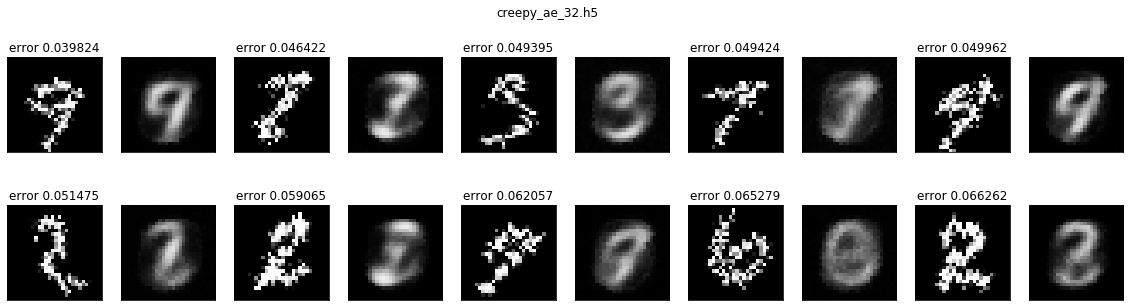

Error:
	creepy_ae_32.h5      0.054


In [30]:
# Load model from the last cell
name = "creepy_ae_%d.h5"%(DIM)

creepy_x_test_pred = model_ae.predict(creepy_x_test)
total_error = np.mean((creepy_x_test_pred-creepy_x_test)**2)

idxs = np.arange(creepy_x_test.shape[0])
np.random.shuffle(idxs)

N = 10
idxs = idxs[:N]
reals = creepy_x_test[idxs]
preds = model_ae.predict(reals)

errors = np.mean((reals-preds)**2,axis=1)
# Sort in increasing error
trf = np.argsort(errors)
reals = reals[trf]
preds = preds[trf]
errors = errors[trf]
#
plt.figure(figsize=(2*N,5))
plt.suptitle(name)
for i in range(N):
    ax = plt.subplot(2,N,2*i+1)
    ax.set_title("error %f"%errors[i])
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(reals[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
    ax = plt.subplot(2,N,2*i+2)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
plt.show()

print("Error:")
print("\t%-20s %.3f"%(name,total_error))

---

### 2.3 *Similarity reconstruct*

En esta sección se explorará una forma diferente de implementar un *autoencoder* que es utilizar la arquitectura del *autoencoder* pero no para reconstruir el mismo dato, sino que para reconstruir un dato similar. En este caso la similaridad estará dada por las clases de los datos.

---

a) Genere pares de objetos $(objeto,similar)$ con 10 datos similares al dato "objeto", para ésto utilice la función que se provee a continuación sobre los primeros (1000 a 2000) datos de entrenamiento. **Visualice los nuevos datos generados y la relación que se produce entre los pares de objetos**.

In [31]:
def similarity_data(X,Y,sim=10):
    index_classes = [np.where(Y==number)[0] for number in range(10)]
    new_X = []
    simi_X = []
    for x,y in zip(X,Y):
        similarities = index_classes[y]
        sample_sim = np.random.choice(similarities,sim)
        new_X.append(np.tile(x,(sim,1)))
        simi_X.append(X[sample_sim])    
    new_X = np.concatenate(new_X,axis=0)
    simi_X = np.concatenate(simi_X,axis=0)
    return new_X,simi_X

data.shape (55000, 784)
data_sim.shape (55000, 784)


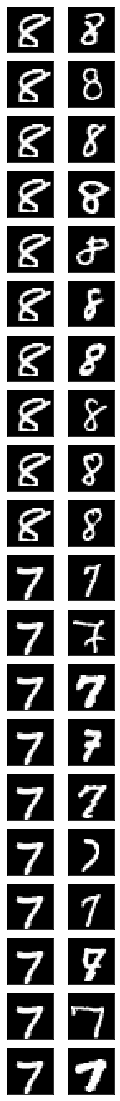

In [32]:
data,data_sim = similarity_data(x_tra_f[:5500],y_tra[:5500])

print("data.shape",data.shape)
print("data_sim.shape",data_sim.shape)

#
N = 20
plt.figure(figsize=(2,N))
#plt.suptitle(name)
for i in range(N):
    ax = plt.subplot(N,2,2*i+1)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(data[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
    ax = plt.subplot(N,2,2*i+2)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(data_sim[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
plt.show()

---

b) Escoja algunas de las arquitecturas ya experimentadas hasta este punto de la actividad y entrénela para enfrentarla a éste problema **¿La función de pérdida se mantiene?**

In [33]:
DIM5 = 16

In [34]:
# ---@> Train models:
dae1,enc1,_ = deep_autoencoder(DIM5,nneurons=(1000,500,250))
dae1.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
dae1.fit(x_tra_f,x_tra_f,epochs=REGULAR_EPOCHS,
        batch_size=REGULAR_BATCH_SIZE,
        validation_data=(x_val_f,x_val_f))
name = "deep_%s_ae_%d.h5"%("regular",DIM5)
dae1.save(name)
enc1.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
name = "deep_%s_e_%d.h5"%("regular",DIM5)
enc1.save(name)

dae2,enc2,_ = deep_autoencoder(DIM5,nneurons=(1000,500,250))
dae2.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
dae2.fit(data,data_sim,epochs=REGULAR_EPOCHS,
        batch_size=REGULAR_BATCH_SIZE,
        validation_data=(x_val_f,x_val_f))
name = "deep_%s_ae_%d.h5"%("similarity",DIM5)
dae2.save(name)
enc2.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
name = "deep_%s_e_%d.h5"%("similarity",DIM5)
enc2.save(name)


Train on 55000 samples, validate on 5000 samples
Epoch 1/80
55000/55000 [==============================] - 9s 159us/step - loss: 0.2295 - val_loss: 0.2273
Epoch 2/80
55000/55000 [==============================] - 7s 118us/step - loss: 0.2097 - val_loss: 0.1001
Epoch 3/80
55000/55000 [==============================] - 7s 118us/step - loss: 0.0730 - val_loss: 0.0700
Epoch 4/80
55000/55000 [==============================] - 7s 118us/step - loss: 0.0698 - val_loss: 0.0692
Epoch 5/80
55000/55000 [==============================] - 7s 119us/step - loss: 0.0691 - val_loss: 0.0687
Epoch 6/80
55000/55000 [==============================] - 7s 118us/step - loss: 0.0686 - val_loss: 0.0681
Epoch 7/80
55000/55000 [==============================] - 7s 118us/step - loss: 0.0680 - val_loss: 0.0676
Epoch 8/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0675 - val_loss: 0.0671
Epoch 9/80
55000/55000 [==============================] - 7s 118us/step - loss: 0.0671 - val_loss: 0.06

55000/55000 [==============================] - 6s 117us/step - loss: 0.0354 - val_loss: 0.0352
Epoch 78/80
55000/55000 [==============================] - 6s 117us/step - loss: 0.0351 - val_loss: 0.0349
Epoch 79/80
55000/55000 [==============================] - 6s 117us/step - loss: 0.0348 - val_loss: 0.0347
Epoch 80/80
55000/55000 [==============================] - 6s 117us/step - loss: 0.0346 - val_loss: 0.0344
Train on 55000 samples, validate on 5000 samples
Epoch 1/80
55000/55000 [==============================] - 9s 157us/step - loss: 0.2291 - val_loss: 0.2258
Epoch 2/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.1546 - val_loss: 0.0718
Epoch 3/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0693 - val_loss: 0.0701
Epoch 4/80
55000/55000 [==============================] - 7s 118us/step - loss: 0.0685 - val_loss: 0.0695
Epoch 5/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0682 - val_loss: 0.0691
Epoch

55000/55000 [==============================] - 6s 118us/step - loss: 0.0580 - val_loss: 0.0546
Epoch 74/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0579 - val_loss: 0.0545
Epoch 75/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0578 - val_loss: 0.0544
Epoch 76/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0577 - val_loss: 0.0543
Epoch 77/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0576 - val_loss: 0.0542
Epoch 78/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0575 - val_loss: 0.0541
Epoch 79/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0575 - val_loss: 0.0541
Epoch 80/80
55000/55000 [==============================] - 6s 118us/step - loss: 0.0574 - val_loss: 0.0540


---

c) **Visualice lo que genera el *autoencoder* dado una imagen de entrada**. Además **visualice, con la herramienta TSNE, los *embedding*/representación reducida** que se producen en el *encoder*.

deep_similarity_ae_16.h5


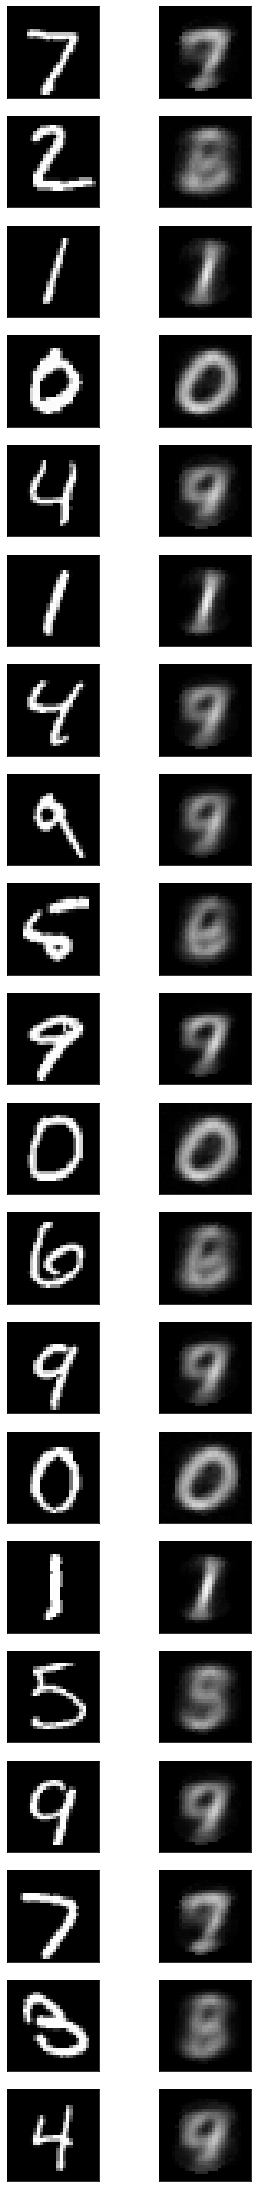

In [35]:
name = "deep_%s_ae_%d.h5"%("similarity",DIM5)
autoenc = keras.models.load_model(name)

N = 20
preds = autoenc.predict(x_test_f[:N])
plt.figure(figsize=(5,2*N))
print(name)
for i in range(N):
    ax = plt.subplot(N,2,2*i+1)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_f[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
    ax = plt.subplot(N,2,2*i+2)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
plt.show()

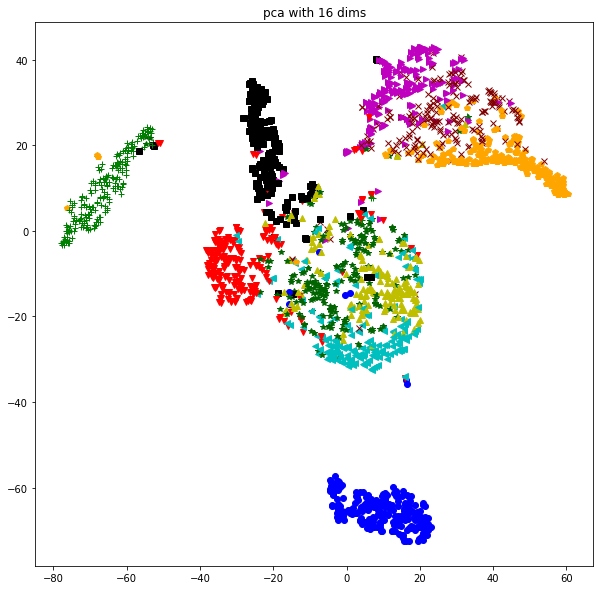

In [36]:
name = "deep_%s_e_%d.h5"%("similarity",DIM5)
encoder = keras.models.load_model(name)

nplot = 2000
enc_tra = encoder.predict(x_tra_f[:nplot])

model = sklearn.manifold.TSNE(n_components=2,random_state=0)
enc_tra = model.fit_transform(enc_tra)

# Plot with tnse:
plt.figure(figsize=(10,10))
plt.title(("autoencoder" if t==0 else "pca")+" with %d dims"%dims)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(nplot):
    label = y_tra[idx]
    line = plt.plot(enc_tra[idx][0],enc_tra[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.show()

---

### 2.4 Pre-*training*

En esta sección utilizaremos un AE para pre-entrenar redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros.

---

a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice SGD básico con tasa de aprendizaje fija $\eta = 0.01$, momentum $m=0.9$ y no más de 50 *epochs*. Para empezar, utilice una arquitectura $768 \times 1000 \times 1000 \times 10$ y **funciones de activación sigmoidales**. **Determine error de clasificación alcanzado por el modelo en el conjunto de test.**

In [37]:
y_tra_c = keras.utils.to_categorical(y_tra, 10)
y_val_c = keras.utils.to_categorical(y_val, 10)
y_test_c = keras.utils.to_categorical(y_test, 10)

In [38]:
def save_dict(dic,fname):
    f = open(fname,'w')
    f.write(str(dic))
    f.close()

def load_dict(fname):
    f = open(fname,'r')
    data = f.read()
    f.close()
    return eval(data)

def plot_errors(data,accuracy=True,name=None):
    labels = sorted([x for x in data])
    loss_labs = [x for x in labels if 'loss' in x]
    acc_labs = [x for x in labels if 'acc' in x]
    n_points = np.max([len(data[la]) for la in labels])
    # Create subplots
    if accuracy:
        fig, (ax1, ax2) = plt.subplots(1,2,sharex=True,figsize=(12,6))
    else:
        fig, ax1 = plt.subplots(1,1,sharex=True,figsize=(12,6))
    fig.suptitle("Metrics v/s epochs"+("" if name is None else " for %s"%name))
    #
    for lab in loss_labs:
        ax1.plot(1+np.arange(n_points),data[lab],label=lab)
    ax1.legend(loc="upper right")
    ax1.set_title("loss")
    ax1.grid(True)
    #
    if accuracy:
        for lab in acc_labs:
            ax2.plot(1+np.arange(n_points),data[lab],label=lab)
        ax2.set_ylim((0,1.0))
        ax2.legend(loc="lower right")
        ax2.set_title("accuracy")
        ax2.grid(True)
    #
    plt.show()

In [39]:
def pretrainable_ffw(activ='sigmoid'):
    input_layer = keras.layers.Input(shape=x_tra_f.shape[1:])
    front = input_layer
    #
    front = keras.layers.Dense(1000, activation=activ)(front)
    ae1_output = keras.layers.Dense(x_tra_f.shape[1])(front)
    ae1 = keras.models.Model(inputs=input_layer,outputs=ae1_output)
    #
    front = keras.layers.Dense(1000, activation=activ)(front)
    ae2_output = keras.layers.Dense(x_tra_f.shape[1])(front)
    ae2 = keras.models.Model(inputs=input_layer,outputs=ae2_output)
    #
    front = keras.layers.Dense(10,activation='softmax')(front)
    ffw = keras.models.Model(inputs=input_layer,outputs=front)
    #
    return ae1,ae2,ffw

In [40]:
ae1,ae2,ffw = pretrainable_ffw()
print("\nAutoencoder 1:")
ae1.summary()
print("\nAutoencoder 2:")
ae2.summary()
print("\nFeed Forward:")
ffw.summary()


Autoencoder 1:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 1000)              785000    
_________________________________________________________________
dense_126 (Dense)            (None, 784)               784784    
Total params: 1,569,784
Trainable params: 1,569,784
Non-trainable params: 0
_________________________________________________________________

Autoencoder 2:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 1000)              785000    
__________________________________

In [41]:
# ---@> Train model:
_,_,ffw = pretrainable_ffw()
optimizer_ = keras.optimizers.SGD(lr=0.01, momentum=0.9)
#
ffw.compile(optimizer=optimizer_,loss='categorical_crossentropy',metrics=['accuracy'])
history_ffw = ffw.fit(x_tra_f,y_tra_c,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,y_val_c))
#
save_dict(history_ffw.history,'ffw_end2end_history.txt')
ffw.save('ffw_end2end.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 7s 134us/step - loss: 1.6437 - acc: 0.4910 - val_loss: 0.8406 - val_acc: 0.7628
Epoch 2/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.6033 - acc: 0.8356 - val_loss: 0.5099 - val_acc: 0.8486
Epoch 3/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.4335 - acc: 0.8766 - val_loss: 0.4250 - val_acc: 0.8774
Epoch 4/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.3802 - acc: 0.8902 - val_loss: 0.3848 - val_acc: 0.8862
Epoch 5/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.3527 - acc: 0.8981 - val_loss: 0.3576 - val_acc: 0.8974
Epoch 6/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.3367 - acc: 0.9012 - val_loss: 0.3445 - val_acc: 0.9016
Epoch 7/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.3241 - acc: 0.9062 - val_loss: 0.3429 - val_acc

In [42]:
# hist = load_dict('ffw_end2end_history.txt')
# plot_errors(hist,name="Feed forward trained end-to-end",accuracy=True)

---

b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Proceda en modo clásico, es decir, entrenando en modo no supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento efectúe un entrenamiento supervisado convencional (*fine-tunning*). **Compare los resultados de clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe también los resultados antes del *fine-tunning*.** Comente.
<!--
```python
from keras.datasets import mnist
... ## Load and preprocess MNIST as usual
...###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')
...###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')
...#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=20, batch_size=25,
shuffle=True, validation_data=(x_val, Y_val))
model.save('Net-768x1000x1000x10-finetunned.h5')
```
-->

In [43]:
# ---@> Train models:
ae1,ae2,ffw = pretrainable_ffw()
optimizer_ = keras.optimizers.SGD(lr=0.01, momentum=0.9)
#
ae1.compile(optimizer=optimizer_,loss='mse')
history_ae1 = ae1.fit(x_tra_f,x_tra_f,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,x_val_f))
save_dict(history_ae1.history,'ffw_pretrain_ae1_history.txt')
ae1.save('ffw_pretrain_ae1.h5')
#
ae2.compile(optimizer=optimizer_,loss='mse')
history_ae2 = ae2.fit(x_tra_f,x_tra_f,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,x_val_f))
save_dict(history_ae2.history,'ffw_pretrain_ae2_history.txt')
ae2.save('ffw_pretrain_ae2.h5')
#
ffw.compile(optimizer=optimizer_,loss='categorical_crossentropy',metrics=['accuracy'])
ffw.save('ffw_pretrain_ffw_before.h5')
history_ffw = ffw.fit(x_tra_f,y_tra_c,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,y_val_c))
save_dict(history_ffw.history,'ffw_pretrain_ffw_history.txt')
ffw.save('ffw_pretrain_ffw.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 6s 110us/step - loss: 0.0787 - val_loss: 0.0677
Epoch 2/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0663 - val_loss: 0.0646
Epoch 3/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0633 - val_loss: 0.0618
Epoch 4/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0606 - val_loss: 0.0591
Epoch 5/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0580 - val_loss: 0.0566
Epoch 6/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0556 - val_loss: 0.0543
Epoch 7/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0533 - val_loss: 0.0521
Epoch 8/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0512 - val_loss: 0.0500
Epoch 9/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0492 - val_loss: 0.0481
Epoch

55000/55000 [==============================] - 6s 101us/step - loss: 0.0465 - val_loss: 0.0460
Epoch 28/50
55000/55000 [==============================] - 6s 101us/step - loss: 0.0458 - val_loss: 0.0453
Epoch 29/50
55000/55000 [==============================] - 6s 101us/step - loss: 0.0451 - val_loss: 0.0446
Epoch 30/50
55000/55000 [==============================] - 6s 101us/step - loss: 0.0445 - val_loss: 0.0440
Epoch 31/50
55000/55000 [==============================] - 6s 101us/step - loss: 0.0438 - val_loss: 0.0434
Epoch 32/50
55000/55000 [==============================] - 6s 101us/step - loss: 0.0433 - val_loss: 0.0428
Epoch 33/50
55000/55000 [==============================] - 6s 102us/step - loss: 0.0427 - val_loss: 0.0423
Epoch 34/50
55000/55000 [==============================] - 6s 101us/step - loss: 0.0422 - val_loss: 0.0418
Epoch 35/50
55000/55000 [==============================] - 6s 101us/step - loss: 0.0417 - val_loss: 0.0413
Epoch 36/50
55000/55000 [========================

55000/55000 [==============================] - 4s 80us/step - loss: 0.1583 - acc: 0.9543 - val_loss: 0.1861 - val_acc: 0.9486
Epoch 42/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.1556 - acc: 0.9553 - val_loss: 0.1835 - val_acc: 0.9484
Epoch 43/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.1521 - acc: 0.9564 - val_loss: 0.1820 - val_acc: 0.9508
Epoch 44/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.1499 - acc: 0.9568 - val_loss: 0.1787 - val_acc: 0.9492
Epoch 45/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.1473 - acc: 0.9575 - val_loss: 0.1753 - val_acc: 0.9510
Epoch 46/50
55000/55000 [==============================] - 4s 79us/step - loss: 0.1443 - acc: 0.9585 - val_loss: 0.1727 - val_acc: 0.9506
Epoch 47/50
55000/55000 [==============================] - 4s 78us/step - loss: 0.1422 - acc: 0.9591 - val_loss: 0.1699 - val_acc: 0.9524
Epoch 48/50
55000/55000 [=====================

In [44]:
ffw_before = keras.models.load_model('ffw_pretrain_ffw_before.h5')
loss = ffw_before.evaluate(x_test_f,y_test_c)
print("Accuracy before fine-tunning: %.4f"%loss[1])
ffw = keras.models.load_model('ffw_pretrain_ffw.h5')
loss = ffw.evaluate(x_test_f,y_test_c)
print("Accuracy after fine-tunning: %.4f"%loss[1])

/home/fcasas/Music/p36env/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


10000/10000 [==============================] - 2s 171us/step
Accuracy before fine-tunning: 0.0982
10000/10000 [==============================] - 2s 169us/step
Accuracy after fine-tunning: 0.9584


---

c) Repita usando funciones de **activación *tanh*. Comente**

In [45]:
# ---@> Train models:
ae1,ae2,ffw = pretrainable_ffw(activ='tanh')
optimizer_ = keras.optimizers.SGD(lr=0.01, momentum=0.9)
#
ae1.compile(optimizer=optimizer_,loss='mse')
history_ae1 = ae1.fit(x_tra_f,x_tra_f,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,x_val_f))
save_dict(history_ae1.history,'ffw_tanh_pretrain_ae1_history.txt')
ae1.save('ffw_tanh_pretrain_ae1.h5')
#
ae2.compile(optimizer=optimizer_,loss='mse')
history_ae2 = ae2.fit(x_tra_f,x_tra_f,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,x_val_f))
save_dict(history_ae2.history,'ffw_tanh_pretrain_ae2_history.txt')
ae2.save('ffw_tanh_pretrain_ae2.h5')
#
ffw.compile(optimizer=optimizer_,loss='categorical_crossentropy',metrics=['accuracy'])
ffw.save('ffw_tanh_pretrain_ffw_before.h5')
history_ffw = ffw.fit(x_tra_f,y_tra_c,epochs=PRETRAIN_EPOCHS,
          batch_size=REGULAR_BATCH_SIZE,shuffle=True,
          validation_data=(x_val_f,y_val_c))
save_dict(history_ffw.history,'ffw_tanh_pretrain_ffw_history.txt')
ffw.save('ffw_tanh_pretrain_ffw.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 6s 114us/step - loss: 0.0964 - val_loss: 0.0712
Epoch 2/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0620 - val_loss: 0.0544
Epoch 3/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0495 - val_loss: 0.0452
Epoch 4/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0422 - val_loss: 0.0394
Epoch 5/50
55000/55000 [==============================] - 4s 74us/step - loss: 0.0373 - val_loss: 0.0353
Epoch 6/50
55000/55000 [==============================] - 4s 74us/step - loss: 0.0337 - val_loss: 0.0322
Epoch 7/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0309 - val_loss: 0.0297
Epoch 8/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0287 - val_loss: 0.0277
Epoch 9/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0269 - val_loss: 0.0260
Epoch

55000/55000 [==============================] - 6s 104us/step - loss: 0.0124 - val_loss: 0.0122
Epoch 28/50
55000/55000 [==============================] - 6s 104us/step - loss: 0.0121 - val_loss: 0.0120
Epoch 29/50
55000/55000 [==============================] - 6s 103us/step - loss: 0.0118 - val_loss: 0.0117
Epoch 30/50
55000/55000 [==============================] - 6s 102us/step - loss: 0.0116 - val_loss: 0.0115
Epoch 31/50
55000/55000 [==============================] - 6s 103us/step - loss: 0.0114 - val_loss: 0.0113
Epoch 32/50
55000/55000 [==============================] - 6s 102us/step - loss: 0.0112 - val_loss: 0.0111
Epoch 33/50
55000/55000 [==============================] - 6s 102us/step - loss: 0.0110 - val_loss: 0.0109
Epoch 34/50
55000/55000 [==============================] - 6s 103us/step - loss: 0.0108 - val_loss: 0.0107
Epoch 35/50
55000/55000 [==============================] - 6s 104us/step - loss: 0.0106 - val_loss: 0.0105
Epoch 36/50
55000/55000 [========================

55000/55000 [==============================] - 4s 81us/step - loss: 0.0089 - acc: 0.9990 - val_loss: 0.0772 - val_acc: 0.9784
Epoch 42/50
55000/55000 [==============================] - 25s 448us/step - loss: 0.0082 - acc: 0.9991 - val_loss: 0.0780 - val_acc: 0.9780
Epoch 43/50
55000/55000 [==============================] - 6s 104us/step - loss: 0.0077 - acc: 0.9993 - val_loss: 0.0770 - val_acc: 0.9794
Epoch 44/50
55000/55000 [==============================] - 5s 91us/step - loss: 0.0074 - acc: 0.9993 - val_loss: 0.0783 - val_acc: 0.9788
Epoch 45/50
55000/55000 [==============================] - 5s 87us/step - loss: 0.0070 - acc: 0.9993 - val_loss: 0.0796 - val_acc: 0.9782
Epoch 46/50
55000/55000 [==============================] - 5s 84us/step - loss: 0.0067 - acc: 0.9995 - val_loss: 0.0811 - val_acc: 0.9774
Epoch 47/50
55000/55000 [==============================] - 5s 83us/step - loss: 0.0063 - acc: 0.9994 - val_loss: 0.0795 - val_acc: 0.9782
Epoch 48/50
55000/55000 [==================

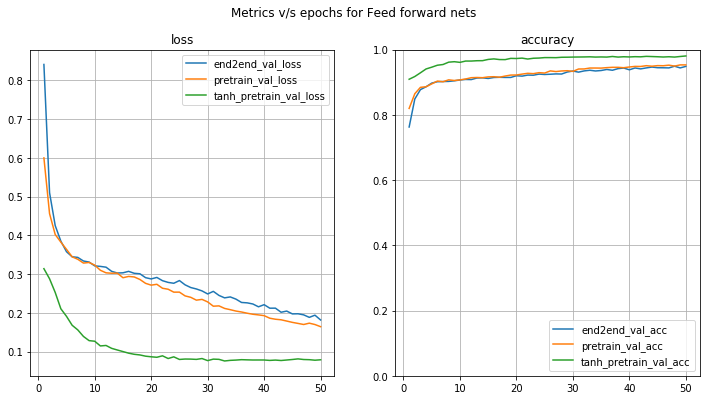

In [46]:
hist1 = load_dict('ffw_end2end_history.txt')
hist2 = load_dict('ffw_pretrain_ffw_history.txt')
hist3 = load_dict('ffw_tanh_pretrain_ffw_history.txt')

dict1 = {'end2end_'+key: hist1[key] for key in hist1 if 'val' in key}
dict2 = {'pretrain_'+key: hist2[key] for key in hist2 if 'val' in key}
dict3 = {'tanh_pretrain_'+key: hist3[key] for key in hist3 if 'val' in key}
dicti = dict1.copy()
dicti.update(dict2)
dicti.update(dict3)

plot_errors(dicti,name="Feed forward nets",accuracy=True)

In [47]:
ffw_before = keras.models.load_model('ffw_tanh_pretrain_ffw_before.h5')
loss = ffw_before.evaluate(x_test_f,y_test_c)
print("Accuracy before fine-tunning: %.4f"%loss[1])
ffw = keras.models.load_model('ffw_tanh_pretrain_ffw.h5')
loss = ffw.evaluate(x_test_f,y_test_c)
print("Accuracy after fine-tunning: %.4f"%loss[1])

/home/fcasas/Music/p36env/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


10000/10000 [==============================] - 2s 173us/step
Accuracy before fine-tunning: 0.1125
10000/10000 [==============================] - 2s 175us/step
Accuracy after fine-tunning: 0.9800


---

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.